### Week 2
# Eniac Business Insights - Data cleaning

## Import modules and load data

In [1]:
# import libraries
import pandas as pd

# load data
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

# Google Drive file ids
files_id = {
    "products": "1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU",
    "orders": "1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ",
    "orderlines": "1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG", 
    "brands": "1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD"
}

# Read data from Google Drive
products = pd.read_csv(gd_path(files_id["products"]), sep=",")
orders = pd.read_csv(gd_path(files_id["orders"]), sep=",")
orderlines = pd.read_csv(gd_path(files_id["orderlines"]), sep=",")
brands = pd.read_csv(gd_path(files_id["brands"]), sep=",")


## Clean orders

- Remove missing values
- Change dates to datetime format
- Recategorize order state "Place Order" as "Pending"?

In [2]:
# Remove rows with missing values
orders = orders.loc[~orders.total_paid.isna(), :]

# Change dates to datetime format
orders["created_date"] = pd.to_datetime(orders["created_date"])

# Recategorize order state "Place Order" as "Pending"?
# orders = orders.state.replace('Place Order', 'Pending')


## Clean orderlines

- Change dates to datetime format
- Remove prices with two decimal points
- Convert prices to numerical data format
- Drop product_id

In [3]:
# Change dates to datetime format
orderlines["date"] = pd.to_datetime(orderlines["date"])

# Remove prices with two decimal points
two_dot_order_ids_list = orderlines.loc[orderlines.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]
orderlines = orderlines.loc[~orderlines.id_order.isin(two_dot_order_ids_list)]

# Convert prices to numerical data format
orderlines["unit_price"] = pd.to_numeric(orderlines["unit_price"])

# Drop product_id
orderlines = orderlines.drop(columns='product_id')


## Clean products

- Drop duplicates
- Remove/replace missing values
- Fix decimal point problems in prices and promo_prices
- Convert prices to numerical data type
- Fix exponential values in type


In [4]:
## Drop duplicates
products.duplicated().sum()
products = products.drop_duplicates()
products = products.drop_duplicates(subset=['sku'])


## Remove/replace missing values
# price
# --> Mostly Celly products
# Could replace missing prices by promo_price assuming that there is only one 
# price but since it's only 0.2% of the data it's probably safer to just remove those rows
products = products.loc[~products.price.isnull(),:]

# type
# --> Mostly (but not only!) Apple iPhones
# Only 0.3% and not clear what to replace with, so drop lines
products = products.loc[~products.type.isnull(),:]

# desc
# Ignore because the desciption is not important for the analysis


## Fix double decimal point problem
# Prices: 
# - move the first point one place to the right
# - remove the second point
double_point_idx_prices = products.price.str.contains('\d+\.\d+\.\d+')
products.loc[double_point_idx_prices,'price'] = products.loc[double_point_idx_prices,'price'].str.replace(r'(\d+)\.(\d)(\d+)\.(\d+)', r'\1\2.\3\4', regex=True)

# Promo prices
# - move the second point one place to the left
# - remove the first point
double_point_idx_promo_prices = products.promo_price.str.contains('\d+\.\d+\.\d+')
products.loc[double_point_idx_promo_prices,'promo_price'] = products.loc[double_point_idx_promo_prices,'promo_price'].str.replace(r'(\d+)\.(\d+)(\d)\.(\d+)$', r'\1\2.\3\4', regex=True)


## Fix 3 decimal places problem: Move decimal point one place to the left
# Prices
triple_dec_idx_prices = products.price.str.contains('\d+\.\d{3}$')
products.loc[triple_dec_idx_prices & ~double_point_idx_prices,'price'] = products.loc[triple_dec_idx_prices & ~double_point_idx_prices,'price'].str.replace(r'(\d*)(\d)\.(\d{3})$', r'\1.\2\3', regex=True)

# Promo prices
triple_dec_idx_promo_prices = products.promo_price.str.contains('\d+\.\d{3}$')
products.loc[triple_dec_idx_promo_prices & ~double_point_idx_promo_prices,'promo_price'] = products.loc[triple_dec_idx_promo_prices & ~double_point_idx_promo_prices,'promo_price'].str.replace(r'(\d*)(\d)\.(\d{3})$', r'\1.\2\3', regex=True)


## Convert prices to numerical data type and round to two decimal places
products.loc[:,'price'] = pd.to_numeric(products['price']).round(2)
products.loc[:,'promo_price'] = pd.to_numeric(products['promo_price']).round(2)


## Fix exponential values in type
# ...



In [5]:
products.info()
products.sort_values(by='price', ascending=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10484 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sku          10484 non-null  object 
 1   name         10484 non-null  object 
 2   desc         10477 non-null  object 
 3   price        10484 non-null  float64
 4   promo_price  10484 non-null  float64
 5   in_stock     10484 non-null  int64  
 6   type         10484 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 655.2+ KB


,sku,name,desc,price,promo_price,in_stock,type
18429,APP2660,"Apple iMac Pro 27 ""18-core Intel Xeon W 23GHz ...",Pro iMac 27 inch screen Retina 5K and Intel Xe...,15339.00,14419.00,0,118692158
18465,APP2696,"Apple iMac Pro 27 ""18-core Intel Xeon W 23GHz ...",Pro iMac 27 inch screen Retina 5K and Intel Xe...,14619.00,13742.01,0,118692158
18428,APP2659,"Apple iMac Pro 27 ""14-core Intel Xeon W 25GHz ...",Pro iMac 27 inch screen Retina 5K and Intel Xe...,14379.00,13516.00,0,118692158
18464,APP2695,"Apple iMac Pro 27 ""14-core Intel Xeon W 25GHz ...",Pro iMac 27 inch screen Retina 5K and Intel Xe...,13659.00,12839.01,0,118692158
18427,APP2658,"Apple iMac Pro 27 ""10-core Intel Xeon 3GHz W |...",Pro iMac 27 inch screen Retina 5K and Intel Xe...,13419.00,12614.00,0,118692158
...,...,...,...,...,...,...,...
17075,SPE0194,Speck CandyShell Case Fit Apple Watch 42mm Tra...,rigid housing with compact design and double l...,1.65,19.99,0,2434
11086,KIN0138,Kingston microSDHC memory card 32GB UHS Class 1,Memory card microSDHC UHS Class 1 32GB with tr...,1.35,16.28,0,57445397
10933,SAN0102,SanDisk Ultra SDHC Class 10 | 16 GB,SDHC Memory Card Class 10 16GB transfer rate o...,0.91,11.00,1,57445397
2364,IFX0020,iFixit P5 Pentalobe Screwdriver,Pentalobe screwdriver P5 for MacBook Air and M...,0.91,10.99,0,14305406


<Axes: >

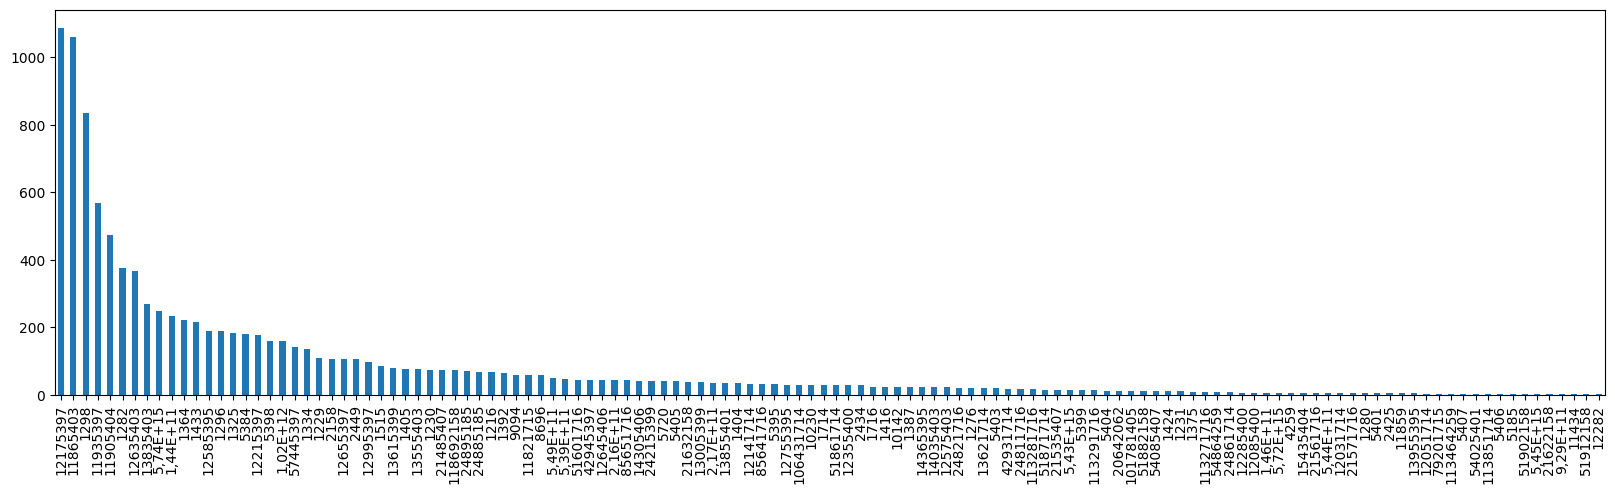

In [6]:
products.groupby('type').first().sample(20)
#Let's search for a correlation between type and e.g. price
products["type"].value_counts().plot.bar(figsize=(20,5))

# Business questions



## 1.&nbsp; How should products be classified into different categories to simplify reports and analysis?


Ideas for categories:


*   **Price ranges**: "low", "medium", "high", "very high"
*   **Type of product**: based on the first 3 letters of the sku we might be able to identify which kind of service we have



The max price is 15339.0 while the minimum is 0.83


array([[<Axes: title={'center': 'price'}>]], dtype=object)

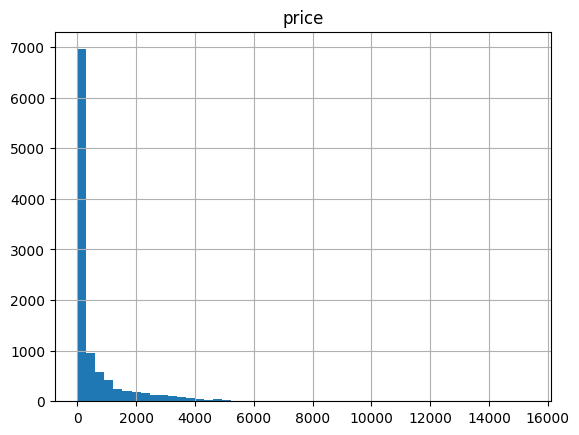

In [7]:
#Price ranges

#We first make an exploratory analysis of prices
max_price = products["price"].max()
min_price = products["price"].min()
print(f"The max price is {max_price} while the minimum is {min_price}")
products[["price"]].hist(bins=50)

In [8]:
# We divide the price into 5 categories from very cheap to very expensive
bins = [0, 20, 50, 100, 500, float('inf')]
labels = ['very cheap', 'cheap', 'medium', 'expensive', 'very expensive']

# Utilizzo della funzione pd.cut() per creare una nuova colonna "price_range"
products['price_range'] = pd.cut(products['price'], bins=bins, labels=labels)
#products

In [9]:
#Relation type of apple product (iMac, Macbook, iPad, iPhone, Watch) and sku or price_range

#products_imac=products.loc[(products["name"].str.contains("iMac")),["sku","name","price","price_range"]].sort_values(by="price", ascending=False).copy()
#products_imac.loc[(products["price_range"]=="very cheap") | (products["price_range"]=="cheap"),:]
#products.loc[(products["price"]>100) & (products["price"]<150) ,:].sort_values(by="price",ascending=False)


## 2.&nbsp; What is the distribution of product prices across different categories?

<Axes: >

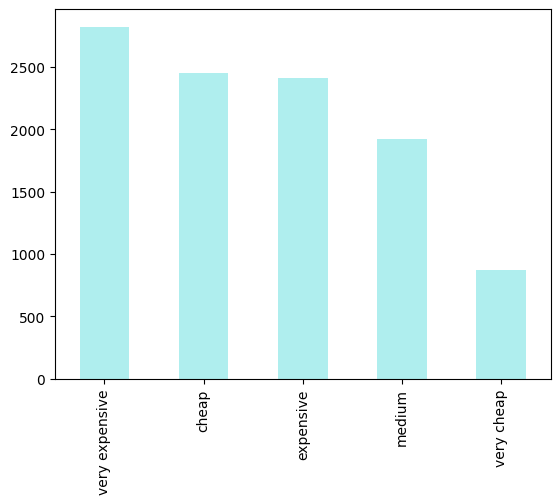

In [10]:
products.price_range.value_counts().plot.bar(color=["paleturquoise","paleturquoise","paleturquoise","paleturquoise","paleturquoise"])

## 3.&nbsp; How many products are being discounted?


In [11]:
#We compare product["price"] with orderlines["unit_price"] (the unitary price (in euros) of each product at the moment of placing that order)
#If orderlines["unit_price"] < product["price"] the product has been discounted

prod_orderlines = products.merge(
    orderlines,
    how = "left",
    left_on="sku",
    right_on="sku"
)[["sku","name","desc","price","unit_price","date"]]

aaa= prod_orderlines.groupby(by="sku").agg("count").reset_index().sort_values("unit_price")
print(f"There are {aaa.loc[aaa['unit_price']==1,:].shape[0]} with 1 unit_pice, {aaa.loc[aaa['unit_price']>1,:].shape[0]} with more and {aaa.loc[aaa['unit_price']==0,:].shape[0]} with 0.")

#Shall we 1) exclude those sku with unit_price = 0, unite_price > price, count(unit_price)>1?

There are 834 with 1 unit_pice, 5838 with more and 3812 with 0.


## 4.&nbsp; How big are the offered discounts as a percentage of the product prices?


## 5.&nbsp; How do seasonality and special dates (Christmas, Black Friday) affect sales?


## 6.&nbsp; How could data collection be improved?